In [337]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import List
import statistics, rich

In [338]:
@dataclass
class Handshake:
    _df: pd.DataFrame
    start: float
    end: float

    @property
    def df(self):
        return self._df.iloc[self.start:self.end]

    def with_offset(self, offset):
        return Handshake(self._df, self.start-offset, self.end+offset)

    @property
    def start_ms(self):
        return self._df['timestamp'].iloc[self.start]

    @property
    def end_ms(self):
        return self._df['timestamp'].iloc[self.end]

    @property
    def diff(self): # in milliseconds
        return round((self.end_ms - self.start_ms) * 1000, 2)

    @property
    def energy(self): # in millijoules
        time_step = 0.000250 # seconds
        joules = (self.df['power'] * time_step).sum()
        return round(joules * 1000, 2)

    def __str__(self) -> str:
        return f"""Duration (ms): {self.diff}
Energy (mJ): {self.energy}"""

    def __repr__(self) -> str:
        dic = {
            "duration": self.diff,
            "energy": self.energy,
        }
        return str(dic)

class DataLoader:
    csv_files_otii = {
        "current": "Main current - Arc.csv",
        "power": "Main power - Arc.csv",
        "gpio": "GPI 1 - Arc.csv",
    }

    def find_handshakes(df):
        # convert NaN to an arbitrary integer
        df['gpio'] = df['gpio'].fillna(-9).astype(int)

        gpio_values = df['gpio'].values
        in_handshake = False
        hs_start, hs_end = 0, 0
        handshakes = []
        for index, value in enumerate(gpio_values):
            if not in_handshake and value == 1:
                in_handshake = True
                hs_start = index
            elif in_handshake and value == 0:
                in_handshake = False
                hs_end = index
                hs = Handshake(df, hs_start, hs_end)
                handshakes.append(hs)

            if in_handshake:
                gpio_values[index] = 1

        # convert temporary value to 0
        gpio_values[gpio_values == -9] = 0
        # Update the 'gpio' column in the DataFrame
        df['gpio'] = gpio_values
        return df, handshakes

    def run(results_dir):
        dfs = []

        for source, csv_file in DataLoader.csv_files_otii.items():
            filename = f"{results_dir}/{csv_file}"
            df = pd.read_csv(filename)
            df = df.rename(columns={'Timestamp': 'timestamp'})
            df = df.rename(columns={'Value': source})
            # print(df.head())
            dfs.append(df)

        merged_df = dfs[0]
        for df in dfs[1:]:
            merged_df = merged_df.merge(df, on="timestamp", how="outer")

        merged_df, handshakes = DataLoader.find_handshakes(merged_df)

        return merged_df, handshakes

def mean_stdev(arr, ndigits=2):
    return round(statistics.mean(arr), ndigits), round(statistics.stdev(arr), ndigits)

@dataclass
class HandshakeSet:
    label: str
    csv_folder: str
    df: pd.DataFrame = field(default_factory=pd.DataFrame)
    handshakes: list = field(default_factory=list)

    def __post_init__(self):
        self.df, self.handshakes = DataLoader.run(self.csv_folder)

    def __getitem__(self, index):
        return self.handshakes[index]

    def duration_mean_stdev(self):
        return mean_stdev([hs.diff for hs in self.handshakes])

    def energy_mean_stdev(self):
        return mean_stdev([hs.energy for hs in self.handshakes])

    def summary(self):
        return {
            'label': self.label,
            'handshakes': len(self.handshakes),
            'duration': self.duration_mean_stdev(),
            'energy': self.energy_mean_stdev(),
        }

edhoc = HandshakeSet("edhoc", "./results/edhoc-09aug-16h24-csv")
# edhoc[0].with_offset(2)
edhoc.summary()

{'label': 'edhoc',
 'handshakes': 100,
 'duration': (182.13, 1.57),
 'energy': (6.33, 0.04)}

In [339]:
edhoc = HandshakeSet("edhoc", "./results/edhoc-09aug-16h24-csv")
dtls = HandshakeSet("dtls", "./results/dtls-09aug-17h26-csv")

In [340]:
(edhoc.summary(), dtls.summary())

({'label': 'edhoc',
  'handshakes': 100,
  'duration': (182.13, 1.57),
  'energy': (6.33, 0.04)},
 {'label': 'dtls',
  'handshakes': 100,
  'duration': (257.94, 2.8),
  'energy': (9.04, 0.07)})

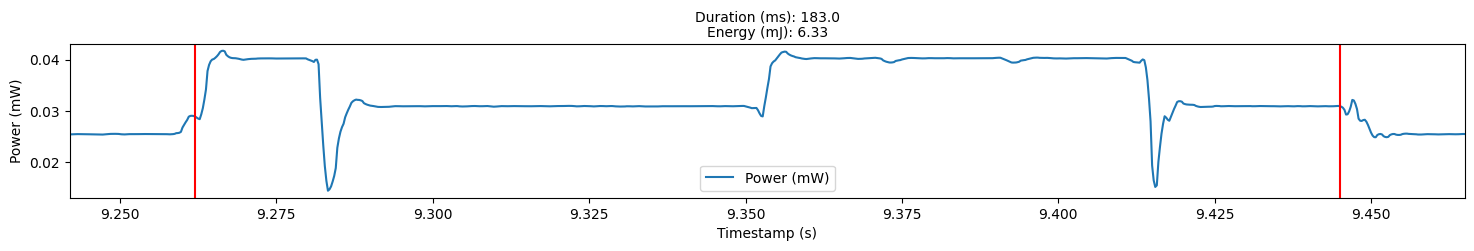

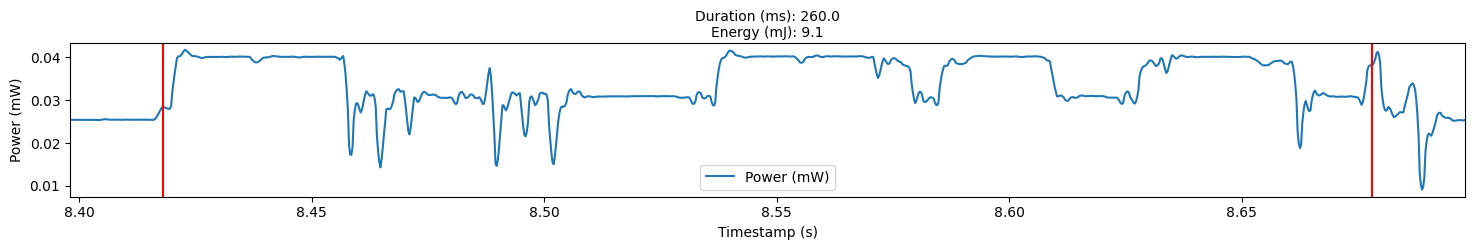

In [341]:
def plot_handshake(hs):
    hs_offset = 200
    xlim_offset = 0.02
    hs_for_plot = hs.with_offset(hs_offset)

    plt.figure(figsize=(18, 2))
    plt.plot(hs_for_plot.df['timestamp'], hs_for_plot.df['power'], label='Power (mW)')

    # draw vertical red lines at start and stop
    plt.xlim(hs.start_ms - xlim_offset, hs.end_ms + xlim_offset)
    plt.axvline(x=hs.start_ms, color='red')
    plt.axvline(x=hs.end_ms, color='red')

    # add duration
    duration_position_x = (hs.start_ms + hs.end_ms) / 2
    y_position = plt.ylim()[1] * 1.03
    plt.text(duration_position_x, y_position, str(hs), ha='center')

    plt.xlabel('Timestamp (s)')
    plt.ylabel('Power (mW)')

    plt.legend()
    plt.show()

# for hs in edhoc.handshakes[:5]:
#     plot_handshake(hs)
plot_handshake(edhoc[0])
plot_handshake(dtls[0])